# `fastai` Baseline for New Tabular Neural Networks

* This notebook shows a basic baseline for `fastai` on three datasets:
  * [Poker Hand Induction](https://www.kaggle.com/c/poker-rule-induction)
  * [Sarcos Robotics Arm Inverse Dynamics](http://www.gaussianprocess.org/gpml/data/)
  * [Higgs Boson](https://archive.ics.uci.edu/ml/datasets/HIGGS)

The goal is to have an accurate baseline score for comparison to other neural networks. There will be a variety of measurements to compare including:

* Overall accuracy
* Number of parameters
* Time to train

In [0]:
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore cudf --upgrade 
!pip install torch==1.3.1
!pip install torchvision==0.4.2
os._exit(00)

# Poker Hand

We'll start with the Poker Hand dataset

In [0]:
from fastai2.tabular.all import *

In [0]:
df = pd.read_csv('train.csv')

In [7]:
len(df.columns)

11

In [8]:
df.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,4,9,2,1,2,2,4,7,2,8,0
1,1,4,3,6,1,12,3,11,2,7,0
2,1,11,4,1,3,7,4,11,2,1,2
3,2,9,2,4,3,6,1,9,4,9,3
4,1,8,2,4,2,11,2,2,2,1,0


* "S" are ordinal data, representing the suits
* "C" are the rank of the cards, numerical data
* Hands are classified 1-9, from "Nothing in hand" to "Royal Flush"

In [0]:
cat_vars = ['S1', 'S2', 'S3', 'S4', 'S5']
cont_vars = ['C1', 'C2', 'C3', 'C4', 'C5']
dep_var = ['hand']

In [10]:
df.isna().sum()

S1      0
C1      0
S2      0
C2      0
S3      0
C3      0
S4      0
C4      0
S5      0
C5      0
hand    0
dtype: int64

We only need to Normalize and Categorify our data

In [0]:
procs = [Categorify, Normalize]

We'll randomly split our data

In [0]:
splits = RandomSplitter()(df)

In [0]:
to = TabularPandas(df, procs, cat_names=cat_vars, cont_names=cont_vars, y_names=dep_var, splits=splits)

In [0]:
dls = to.dataloaders(bs=512)

Let's take a look at our new data

In [15]:
dls.show_batch()

,S1,S2,S3,S4,S5,C1,C2,C3,C4,C5,hand
0,1,4,1,4,3,7.0,6.0,4.0,1.0,10.0,0
1,3,1,2,2,4,13.0,4.0,10.0,6.0,8.0,0
2,3,1,4,1,1,11.0,2.0,10.0,5.0,7.0,0
3,3,1,2,1,2,5.0,1.0,8.0,11.0,11.0,1
4,2,1,4,4,3,5.0,4.0,5.0,1.0,1.0,2
5,1,2,2,4,4,4.0,1.0,2.0,11.0,12.0,0
6,3,4,4,1,4,5.0,7.0,10.0,5.0,4.0,1
7,3,4,1,3,3,11.0,6.0,12.0,3.0,6.0,1
8,1,2,4,4,4,7.0,3.0,10.0,8.0,2.0,0
9,4,2,3,1,1,7.0,13.0,4.0,5.0,10.0,0


Now we can build our model and fit!

In [16]:
dls.vocab

(#10) [0,1,2,3,4,5,6,7,8,9]

In [0]:
learn = tabular_learner(dls, layers=[1000,500], metrics=accuracy, opt_func=ranger, loss_func=CrossEntropyLossFlat())

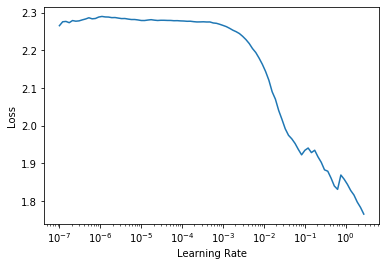

In [37]:
learn.lr_find()

In [21]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.183060,0.995439,0.536186,00:00
1,1.047497,0.966100,0.526789,00:00
2,0.981486,0.981577,0.529188,00:00
3,0.948433,0.957529,0.534186,00:00
4,0.910991,0.957820,0.535186,00:00


In [0]:
class CalcPermutationImportance():
  def __init__(self, df:pd.DataFrame, learn:Learner, rounds:int, metric:callable):
    self.df, self.learn, self.rounds = df, learn, rounds
    self.learn.metrics = L(AvgMetric(metric))
    dls = learn.dls
    self.procs = [Categorify, Normalize]
    self.cats, self.conts = dls.cat_names, dls.cont_names
    self.cats = self.cats.filter(lambda x: '_na' not in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))
    
  def calc_feat_importance(self):
    to_test = self.learn.dls.test_dl(self.df)
    base_error = self.learn.validate(dl=to_test)[1]
    self.importance = {}
    pbar = master_bar(self.cats + self.conts, total=len(self.cats + self.conts))
    for col in pbar:
      self.importance[col] = self.calc_error(col)
      _ = progress_bar(range(1), display=False, parent=pbar)
      
    for key, value in self.importance.items():
        self.importance[key] = (base_error - value)/base_error
    return collections.OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))
  
  def calc_error(self, sample_col:Str):
    df_temp = pd.concat([self.df]*self.rounds, ignore_index=True).copy()
    
    df_temp[sample_col] = np.random.permutation(df_temp[sample_col].values)
    to_test = self.learn.dls.test_dl(df_temp)
    return self.learn.validate(dl=to_test)[1]
  
  def ord_dic_to_df(self, ord_dict:OrderedDict)->pd.DataFrame:
      return pd.DataFrame([[k, v] for k, v in ord_dict.items()], columns=['feature', 'importance'])
    
  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False):
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    ax = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc)).plot.barh(x="feature", y="importance", sort_columns=True, figsize=(10, 10))
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

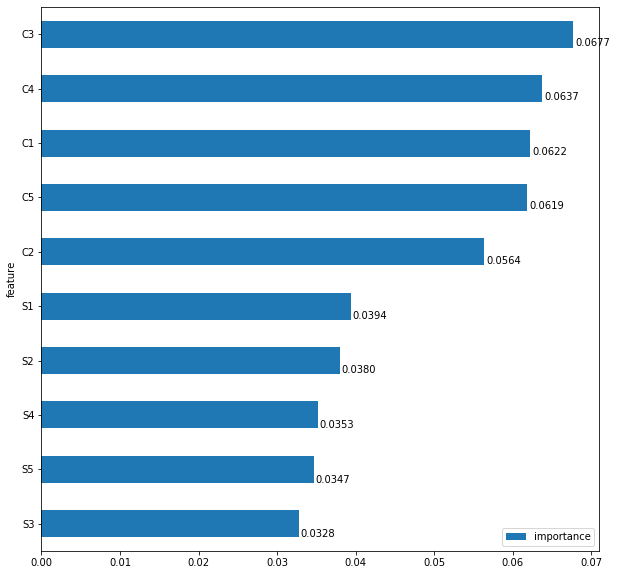

In [23]:
res = CalcPermutationImportance(df, learn, 5, accuracy)

Let's try just keeping the numerical

In [0]:
to = TabularPandas(df, procs, cat_names=[], cont_names=cont_vars, y_names=dep_var, splits=splits)

In [0]:
dls = to.dataloaders(bs=512)

In [0]:
learn = tabular_learner(dls, layers=[1000,500], metrics=accuracy, opt_func=ranger, loss_func=CrossEntropyLossFlat())

In [31]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.197854,1.099801,0.526389,00:00
1,1.074150,0.952505,0.566973,00:00
2,0.999797,0.940425,0.565774,00:00
3,0.953768,0.903270,0.573770,00:00
4,0.912987,0.880105,0.598960,00:00


Post pruning we got to 59%. Still no where near their alleged 99%, nor the [Deep Neural Decision Tree](https://github.com/wOOL/DNDT) (DNDT) of 65%, but this is just a baseline

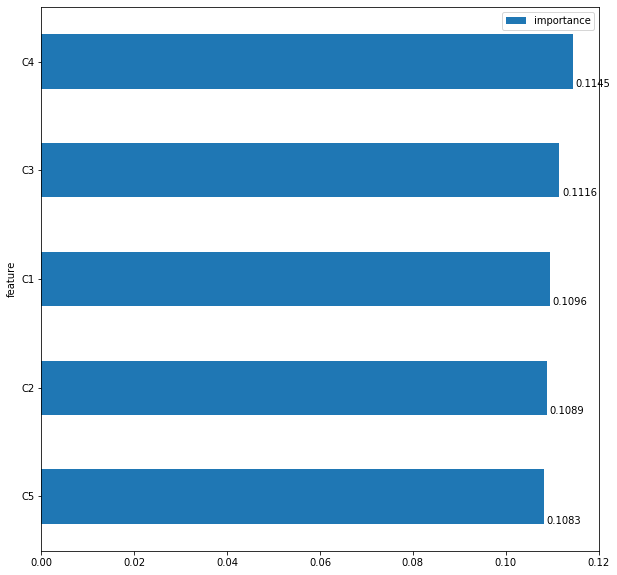

In [32]:
res = CalcPermutationImportance(df, learn, 5, accuracy)

In [0]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [34]:
get_n_params(learn.model)

512030

So our model has ~512k parameters

# Sarcos Robotics Arm Inverse Dynamics

In [78]:
!pip install mat4py

In [0]:
from mat4py import *

In [0]:
data = loadmat('sarcos_inv.mat')

In [0]:
train_df = pd.DataFrame(data['sarcos_inv'])

In [38]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.019478,-0.134218,0.027439,1.516401,0.300936,0.058259,0.150134,-0.266791,-0.237134,-0.091272,1.549958,-0.006883,0.012774,-1.930253,13.439378,-8.935911,14.242047,13.520240,11.695956,1.210212,-22.119289,50.292652,-36.971897,20.937170,47.821712,-0.424812,-0.907553,8.090739
1,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,1.670677,0.085485,0.017012,-2.211089,11.989628,-7.781117,11.613101,9.550076,14.643369,1.015070,-17.048688,44.104164,-28.851845,16.230194,43.194073,-0.228739,-1.235817,7.762475
2,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,1.721737,0.326621,0.015857,-2.337160,9.961797,-5.468357,9.550884,5.933340,15.467628,0.910548,-11.415526,37.354858,-20.809343,12.379975,39.386017,0.244491,-1.700880,7.289678
3,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,1.740283,0.579685,0.007958,-2.331961,7.332938,-2.434889,7.664916,3.964112,10.309203,0.921360,-5.772058,30.676065,-13.963816,7.702940,36.478813,-0.182062,-2.143370,6.410800
4,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,1.770296,0.608002,-0.001271,-2.249311,3.797804,0.467865,6.160604,3.175643,2.868096,1.059957,-0.491542,25.920128,-11.178479,5.643934,34.773911,-1.031687,-2.355776,5.792892


In [0]:
data = loadmat('sarcos_inv_test.mat')

In [0]:
test_df = pd.DataFrame(data['sarcos_inv_test'])

In [41]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.019478,-0.134218,0.027439,1.516401,0.300936,0.058259,0.150134,-0.266791,-0.237134,-0.091272,1.549958,-0.006883,0.012774,-1.930253,13.439378,-8.935911,14.242047,13.520240,11.695956,1.210212,-22.119289,50.292652,-36.971897,20.937170,47.821712,-0.424812,-0.907553,8.090739
1,0.022776,-0.171351,0.052760,1.693492,0.342656,0.059794,-0.050100,0.084847,-0.255626,0.382405,1.646871,0.446238,0.107600,-1.294961,1.513093,2.435272,-1.696192,-12.403740,-2.012829,2.495671,16.674191,15.940047,-13.061279,2.427498,17.963486,-0.546187,-0.811005,2.992994
2,0.032390,-0.181938,0.077327,1.781017,0.369454,0.080508,-0.100733,0.045868,0.004528,0.064765,0.005510,0.040401,0.089512,0.103072,-2.110077,0.935575,-4.947413,-16.986576,-3.285896,-2.966357,13.061522,7.037463,-9.188517,0.881758,7.645592,-0.650692,-1.178520,0.915749
3,0.030222,-0.166262,0.070321,1.701064,0.354783,0.073603,-0.027851,-0.088346,0.270796,-0.192302,-1.385678,-0.339460,-0.171236,1.265621,-2.304167,0.465381,-4.213378,-7.584241,-1.019358,-3.954764,7.878329,14.583553,-13.596826,2.193129,19.832533,-0.844057,-1.965107,3.067265
4,-0.028086,-0.135443,0.016349,1.576217,0.317178,0.027572,0.114844,-1.299513,0.323785,-0.890498,-0.415264,-0.516554,-0.721413,1.150356,-8.964402,-3.955607,-4.758108,26.506675,-0.854014,2.552390,-21.796940,21.884100,-27.049292,9.527929,48.246521,-1.153062,-2.413705,7.530760


We have no numerical data here, the task is to map from a 21D space the torques. 

In [0]:
splits = RandomSplitter()(train_df)

In [0]:
procs = [Normalize]

In [0]:
to = TabularPandas(train_df, procs, cat_names=[], cont_names=list(range(0,27)), 
                   y_names=27, splits=splits, block_y=TransformBlock())

In [0]:
dls = to.dataloaders(bs=512)

In [14]:
dls.show_batch()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.284314,-0.300722,0.263938,1.078463,0.430590,0.128840,0.328120,-0.066234,0.004437,-0.395271,0.780850,-0.169360,0.165091,-0.576570,-15.571794,-2.973764,0.573734,45.730827,2.125872,-1.301264,-25.133738,14.619392,-73.522537,27.161417,50.204605,-1.941998,-0.115858,8.901744
1,0.299026,-0.345864,0.092102,1.434149,-0.027890,0.126649,0.115379,1.011401,-0.042454,-0.198875,-1.150881,0.095309,-0.184367,-0.698695,-6.984077,1.919412,-3.640036,1.282979,-0.315821,-0.036286,1.953525,13.456683,-26.505587,7.707306,20.997858,-1.092374,-0.212406,2.741969
2,-0.475079,-0.419976,0.003896,1.751282,0.431938,-0.303976,0.196097,-0.260938,-0.823386,0.870899,1.846933,1.341678,-0.142141,-1.762325,1.220934,1.619547,3.529968,-3.981805,1.619994,4.454813,1.060612,-0.407777,-23.922993,15.171863,27.370041,0.728249,-1.370984,4.421907
3,-0.299761,-0.409450,0.106019,1.689277,0.064504,0.161172,0.371617,0.491405,0.005391,-0.227116,-0.024032,-0.197046,-0.078426,-0.284996,11.642443,-0.294714,-7.465520,-1.479348,-2.054055,-2.866470,-3.951807,44.855606,-14.680017,-4.733621,31.071974,-2.124061,-3.591593,3.997096
4,0.144114,-0.479036,0.173092,1.414357,0.062022,0.116676,0.127653,0.046032,-0.010987,-0.114542,-0.100789,-0.008796,-0.001689,-0.023217,-10.152224,4.250528,-10.458148,7.151736,-0.594025,-2.080068,8.470665,-2.446669,-16.039278,4.551558,23.000546,-0.970999,-0.154477,3.301949
5,-0.513249,-0.478284,0.075556,1.943265,0.540322,-0.270220,0.028851,-0.641220,-0.014004,0.038629,0.035035,0.121540,-0.009978,0.479448,-1.939703,5.295237,-11.761228,-15.173553,-9.666317,-2.896394,15.243329,-14.680016,-12.505200,2.124061,8.738993,-0.970999,-3.301949,0.231716
6,0.231859,-0.467161,0.152452,1.407162,0.044524,0.122813,0.113844,-0.136683,0.000367,0.001046,0.035911,-0.015109,0.009240,0.050473,-9.103110,1.358829,-1.421005,6.806735,0.020598,0.171525,5.643709,0.815557,-32.758186,14.564987,24.092918,-1.456499,1.641319,3.591593
7,-0.126094,-0.392203,0.020756,1.630435,0.116372,0.055302,0.260376,3.527043,-0.441091,0.692143,-3.803262,0.366814,0.416729,-2.861829,8.908041,-10.515388,-3.695605,-13.475200,-1.282855,-4.542986,1.976202,42.816719,-38.603008,15.900112,32.771221,-1.699249,-0.038619,4.672933
8,-0.505482,-0.628915,0.073086,2.012741,0.859134,-0.381335,-0.044729,-0.415102,0.046629,-0.476902,-1.757590,-1.021844,-1.404500,1.608016,5.410340,3.430774,-5.857467,-15.774460,-6.443140,-1.847194,6.503639,1.359262,-26.777439,12.562303,11.166491,-0.667562,-1.313056,2.317157
9,-0.294546,-0.406214,-0.255609,1.905136,0.014522,-0.107341,0.494365,-1.199725,-0.409293,-0.262556,0.720200,-0.014265,-0.310044,1.010094,1.555699,0.030255,1.615503,-7.780575,-0.295719,1.462557,-4.319641,3.262226,-22.971510,10.802365,19.844795,-0.424812,0.077239,2.181989


In [0]:
learn = tabular_learner(dls, layers=[1000,500], opt_func=ranger, loss_func=MSELossFlat(),
                        n_out=1, metrics = mse)

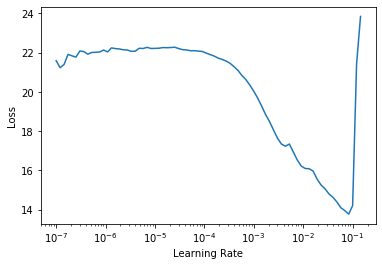

In [18]:
learn.lr_find()

In [52]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,mse,time
0,0.807185,0.216886,0.216886,00:01
1,0.255078,0.062381,0.062381,00:01
2,0.202140,0.181921,0.181921,00:01
3,0.165763,0.060520,0.060520,00:01
4,0.088481,0.038586,0.038586,00:01


In [0]:
dl = learn.dls.test_dl(test_df)

In [54]:
learn.validate(dl=dl)

(#2) [0.03403851389884949,0.03403851389884949]

In [84]:
preds = []
for i in range(len(test_df)):
  preds.append(learn.predict(test_df.iloc[i])[1])

In [0]:
gt = test_df[27].values

In [86]:
len(preds) == len(gt)

True

In [87]:
len(preds)

4449

In [0]:
summation = 0
n = len(gt)

In [89]:
gt[0]

8.090739

In [90]:
preds[0]

tensor([7.9382])

In [0]:
for i in range(0, n):
  diff = gt[i] - preds[i]
  sqr = diff**2
  summation += sqr
MSE = summation/n

In [92]:
MSE

tensor([0.0340])

They achieved a 0.14 on theirs, point for us!

In [93]:
get_n_params(learn.model)

529609

# Higgs Boson

"Using simulated data with features characterizing events detected by ATLAS, your task is to classify events into "tau tau decay of a Higgs boson" versus "background.""

In [99]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'

--2020-02-01 02:39:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  21.4MB/s    in 2m 4s   

2020-02-01 02:41:39 (21.6 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [0]:
from fastai2.tabular.all import *

In [0]:
import gzip

In [4]:
with gzip.open('HIGGS.csv.gz') as f:
    df = pd.read_csv(f)

df.head()

,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00.1,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [0]:
numpy = df.to_numpy()

In [0]:
columns = ['label', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 
           'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag',
           'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 
           'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta',
           'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv',
           'm_bb', 'm_wbb', 'm_wwbb']

In [0]:
del df

In [0]:
df = pd.DataFrame(numpy, columns=columns)

In [9]:
df.head()

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [0]:
dictionary = {1.0:'yes',0.0:'no'}

In [0]:
df.replace({'label': dictionary}, inplace=True)

Much better. Let's try making our model. The last 500,000 rows are our test set

In [0]:
splits = IndexSplitter(range(len(df)-500000, len(df)))(df)

In [113]:
splits

((#10499999) [0,1,2,3,4,5,6,7,8,9...],
 (#500000) [10499999,10500000,10500001,10500002,10500003,10500004,10500005,10500006,10500007,10500008...])

In [0]:
procs = [Normalize]

In [0]:
to = TabularPandas(df, procs, cat_names=[], cont_names=columns[1:], 
                   y_names='label', splits=splits)

In [0]:
dls = to.dataloaders(bs=512)

In [0]:
learn = tabular_learner(dls, layers=[1000,500], opt_func=ranger, 
                        metrics=accuracy)

In [28]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.498860,0.494958,0.753740,05:43
1,0.495847,0.492617,0.755006,05:42
2,0.490820,0.487795,0.758954,05:32
3,0.489521,0.487190,0.759100,05:26
4,0.475516,0.471221,0.769428,05:30


This matches large gradient boosted trees, but does not match TabNet

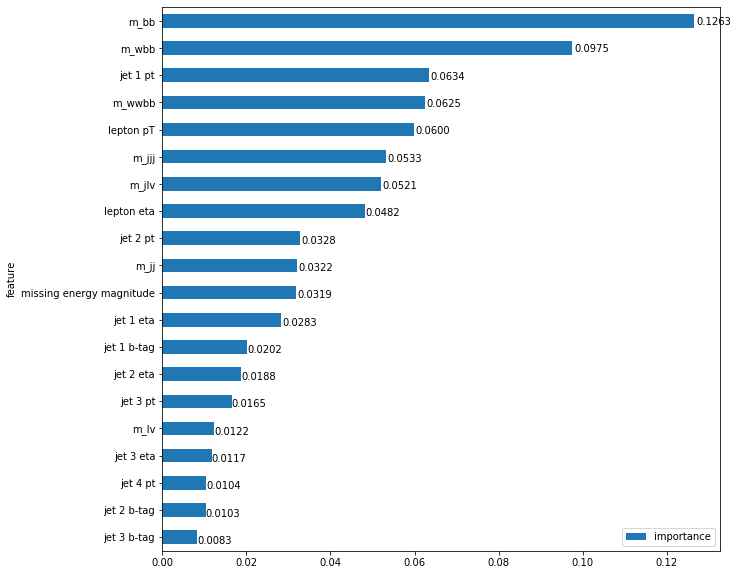

In [33]:
res = CalcPermutationImportance(df.iloc[10499999:], learn, 5, accuracy)